In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [10]:

measurement_df = pd.read_sql('select * from measurement', engine)
measurement_df.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [11]:
station_df = pd.read_sql('select * from station', engine)
station_df.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


# Exploratory Climate Analysis

2016-08-23 00:00:00


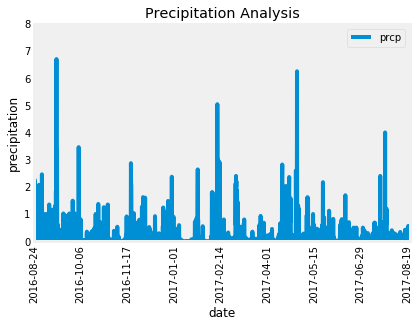

In [12]:

# Design a query to retrieve the last 12 months of precipitation data and plot the results
prcp_date = session.query(Measurement).order_by(Measurement.date.desc()).limit(1)

for value in prcp_date:
    latest_date_value = value.date

#Converting the date to from str format to date format to calculate the date 1 year ago

converted_date = dt.datetime.strptime(latest_date_value, "%Y-%m-%d")

# Calculate the date 1 year ago from the last data point in the database
date_one_yearago = converted_date - dt.timedelta(days=365)
print(date_one_yearago)
# Perform a query to retrieve the date and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= date_one_yearago).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data, columns=['date', 'prcp'])
#prcp_df.dropna()

indexed_df = prcp_df.dropna().set_index('date')


# Sort the dataframe by date
sorted_df = indexed_df.sort_values(by='date')
reset_df = sorted_df.reset_index()


# Use Pandas Plotting with Matplotlib to plot the data
#plt.bar(reset_df['date'], reset_df['prcp'], align='center', color='b', alpha=1)
sorted_df.plot(rot=90)
plt.title("Precipitation Analysis")
plt.xlabel("date")
plt.ylabel("precipitation")
plt.ylim(0,8)
#plt.legend('prcp', loc ='upper center')
plt.grid()
plt.show()

![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
reset_df['prcp'].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

![describe](Images/describe.png)

In [14]:
# Design a query to show how many stations are available in this dataset?
number_stations = session.query(Measurement.station).distinct(Measurement.station).count()
print(number_stations)

9


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_list = session.query(Measurement.station, func.count('*')).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_list

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
#get the most active station from the above list
mostactive=station_list[0][0]
print(mostactive)

USC00519281


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel = [Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs),
       func.count(Measurement.tobs)]

active_station_stats = session.query(*sel).\
    filter(Measurement.station == mostactive).all()

active_station_stats

[('USC00519281', 54.0, 85.0, 71.66378066378067, 2772)]

![precipitation](Images/station-histogram.png)

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
mostactive_latestdate = session.query(Measurement).\
    filter(Measurement.station==mostactive).order_by(Measurement.date.desc()).limit(1)

for value in mostactive_latestdate:
    latestdate = value.date

#Converting the date from str format to date format to calculate the date 1 year ago

converted_activedate = dt.datetime.strptime(latestdate, "%Y-%m-%d")

# Calculate the date 1 year ago from the last data point of the most active station in the database
date_one_activeyear = converted_activedate - dt.timedelta(days=365)
date_one_activeyear

datetime.datetime(2016, 8, 18, 0, 0)

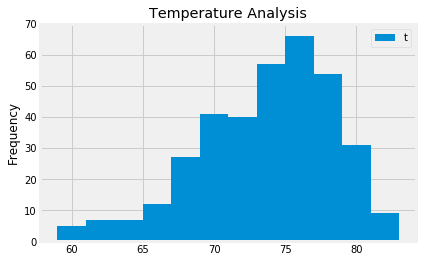

In [19]:
# Perform a query to retrieve the date and temperature obersvations of most active station
temp_data = session.query(Measurement.tobs).\
            filter(Measurement.station==mostactive).\
            filter(Measurement.date >= date_one_activeyear).order_by(Measurement.date).all()
temp_df = pd.DataFrame(temp_data, columns=['tobs'])

plt.hist(temp_df['tobs'], bins=12)
plt.title("Temperature Analysis")
plt.ylabel("Frequency")
plt.ylim(0,70)
plt.legend('tobs', loc = 'upper right')

plt.show()

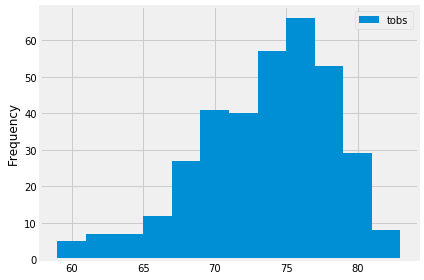

In [20]:
results = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= '2016-08-23').all()
df = pd.DataFrame(results, columns=['tobs'])
df.plot.hist(bins=12)
plt.tight_layout()

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_stats = calc_temps('2017-08-10', '2017-08-23')
trip_stats

[(70.0, 78.71428571428571, 85.0)]

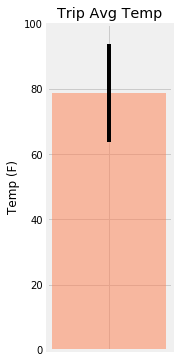

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


avg_temp=trip_stats[0][1]
yerr = trip_stats[0][2] - trip_stats[0][0]
plt.figure(figsize=(2,6))
plt.bar('', avg_temp, yerr = yerr, align='center', alpha=0.5, ecolor='black', color = 'coral')
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.ylim(0,100)

plt.show()

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
total_rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
                 filter(Measurement.station == Station.station).\
                 filter(Measurement.date >= '2017-08-10').\
                 filter(Measurement.date <= '2017-08-23').\
                 group_by(Station.station).\
                 order_by(func.sum(Measurement.prcp).desc()).all()

print(total_rainfall)


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 3.0), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.51), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.34), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.04), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.02)]


## Optional Challenge Assignment

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [28]:
# Plot the daily normals as an area plot with `stacked=False`
